# Assignment 2

### This notebook consists of 2 parts: 
    - Page rank, HITS;
    - Community detection

### You can receive max 10 points for both.


## Complete [this form](https://forms.gle/jvgXHSMaNvygWvCz5) with your name, email and .ipynb until 12.03 23:59 msk

# Page rank and HITS

In [191]:
import numpy as np
from typing import List, Tuple
import networkx as nx

### Task 1. PageRank algorithm (2.5 points)

Implement PageRank algorithm. A function `page_rank` takes a graph, transition coefficient `alpha` and number of iterations `k`. The function returns np.array of PageRank scores.

In [57]:
def page_rank(nodes : np.ndarray, edges : List[np.ndarray], alpha : float, k : int) -> np.ndarray:
    P = transition_matrix(edges)
    v = teleportation_vector(edges)
    rank = np.ones(nodes.shape[0]) / nodes.shape[0]
    for _ in range(k):
        rank = update_rank(rank, P, v, alpha)
    return rank / rank.sum()

Write a function `transition_matrix` that takes a np.array with an adjacency list and returns a np.array with a transition matrix where an entry $p_{ij}$ equals to probability of going to $j$ if we are in $i$.

In [48]:
def transition_matrix(edges : List[np.ndarray]) -> np.ndarray:
    return np.nan_to_num(edges/np.sum(edges, axis = 1)[:, None], 0)

In [49]:
A = [[0, 1, 1], # probability P(0→1) = P(0→2) = 1/2
     [0, 0, 1], # probability P(1→2) = 1
     [1, 0, 0]] # probability P(2→0) = 1
A = np.array(A)
tran_sum = transition_matrix(A).sum(axis=1)
assert tran_sum[0] == tran_sum[1] == tran_sum[2] == 1

Write a function `teleportation_vector` that takes a np.array with an adjacency list and returns a np.array with a teleportation vector where $p_i$ is a probability to teleport to a node $i$ (by default it is a uniform distribution).

In [50]:
def teleportation_vector(edges : np.ndarray) -> np.ndarray:
    # Your code here
    return np.ones(edges.shape[0])/edges.shape[0]

In [51]:
assert teleportation_vector(A).sum() == 1

Write a function `update_rank`. Check the function `page_rank` to understand parameters. An iterative process is defined as

$$\begin{matrix}
r &=& \text{transition} &+& \text{teleportation}\\
r &=& \alpha P^T r &+& (1 - \alpha)v
\end{matrix}
$$

where $P$ is a transition matrix, $v$ is a teleportation vector.

In [52]:
def update_rank(rank : np.ndarray, P : np.ndarray, v : np.ndarray, alpha : float) -> np.ndarray:
    r = alpha * P.T @ rank + (1 - alpha) * v
    return r

In [53]:
def get_adj_list(edges): # направленный граф!
    shape = edges.max() - edges.min() + 1
    adj = np.zeros((shape, shape))
    for edge in edges:
        adj[edge[0]][edge[1]] = 1
        #adj[edge[1]][edge[0]] = 1
    return adj

In [60]:
G = nx.path_graph(6, create_using=nx.DiGraph)
nodes = np.array(G.nodes)
edges = np.array(G.edges)
adj_list = get_adj_list(edges)
pr = page_rank(nodes, adj_list, 0.9, 100)
assert np.all(pr[1:] - pr[:-1] > 0)

/tmp/ipykernel_60434/3442914366.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(edges/np.sum(edges, axis = 1)[:, None], 0)


In [63]:
pr

array([0.05608622, 0.10656383, 0.15199367, 0.19288053, 0.2296787 ,
       0.26279705])

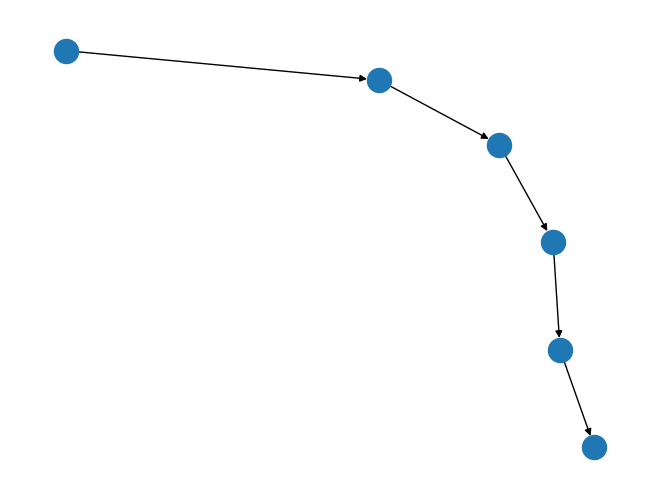

In [17]:
nx.draw(G)

### Task 2. HITS (2.5 points)

In this task we will try to find authorities and hubs in political blogs and visualize them. The data is provided from [Political blogosphere Feb. 2005](http://vlado.fmf.uni-lj.si/pub/networks/data/mix/mixed.htm) dataset.

The graph contains parallel edges, but HITS algorithm only works without parallel edges. The simplest way to drop parallel edges is to convert a directed multigraph into a directed graph.

Write a function `hits_polblogs` that takes a path to a gml file with data and returns a tuple with a graph and two dictionaries of the form
* `{node: value}`

The first dictionary is hub scores, the second one is authority scores. That is, a full output is `(nodes, adj_list, hub, auth)`. Apply `nx.hits` to calculate hub and authority scores.

In [220]:
def hits_polblogs(filename : str) -> [np.array, List[np.ndarray], dict, dict]:
    G = nx.DiGraph(nx.read_gml(filename)).to_directed()
    return G.nodes, G.edges, *nx.hits(G)

In [221]:
# url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/polblogs.gml'
# open('polblogs.gml', 'wb').write(requests.get(url).content)
_, _, hub, auth = hits_polblogs('polblogs.gml')
assert len(hub.values()) == len(auth.values()) == 1490
assert round(max(hub.values()), 4) == 0.0069
assert round(max(auth.values()), 4) == 0.015

There are many edges and nodes and it makes hard to draw the whole graph. Then, let us draw a scatter plot with hub and authority scores.

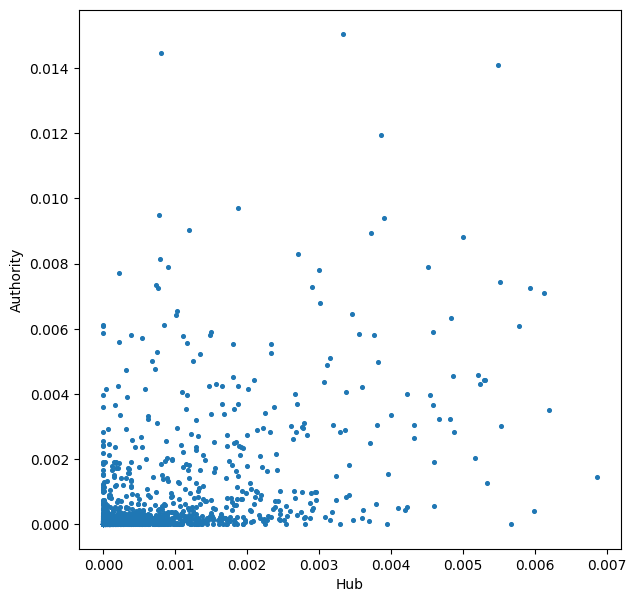

In [222]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7, 7))
plt.scatter(hub.values(), auth.values(), s=7)
plt.xlabel('Hub')
plt.ylabel('Authority')
plt.show()

Next, draw a graph with 14 nodes: top 7 authorities and top 7 hubs. Hubs will be on the left, authorities will be on the right.

Write a function `hits_visualization` that takes a graph, hub, authority dictionaries, the number of top nodes and returns a dictionary with keys:
* `h_top` — np.array of top nodes by hub score
* `a_top` — np.array of top nodes by authority score
* `subG` — subgraph of `G` with top nodes only
* `h_vals` — np.array with hub scores (in initial graph) of top nodes that ordered by `subG.nodes` view 
* `a_vals` — the same for authority score
* `pos` — dictionary with keys are nodes and values are x-y positions of the form

`{node: [x, y]}` where 
* x equals to 0 if it is a hub and 1 if it is a authority
* y equals to an index of top array

That is, x could be 0 or 1 and y could be 0, 1, ..., 6.

In [223]:
def hits_visualization(nodes : np.ndarray, edges : List[np.ndarray], hub : dict, auth : dict, top : np.ndarray) -> dict:
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    h_top = dict(sorted(hub.items(), key=lambda x: x[1], reverse=True)[:top])
    h_top = np.array(list(h_top.keys()))
    a_top = dict(sorted(auth.items(), key=lambda x: x[1], reverse=True)[:top])
    a_top = np.array(list(a_top.keys()))
    
    idx_top = np.where(np.isin(nodes, np.array(list(set(nodes).intersection(set(h_top).union(set(a_top)))))))
    subg_nodes = nodes[idx_top]
    subG = G.subgraph(subg_nodes)
    
    h_vals = np.array(list(map(lambda x: hub[x], subg_nodes)))
    a_vals = np.array(list(map(lambda x: auth[x] if auth[x]>=0 else 0, subg_nodes)))
    
    pos = {}
    for i, node in enumerate(subg_nodes):
        x = 0 if node in h_top else 1
        if x ==0:
            y = np.where(h_top == node)[0].item()
        else:
            y = np.where(a_top == node)[0].item()
        pos.update({node: [x,y]})
        
    return {'h_top': h_top, 'a_top': a_top, 'subG': subG, 'h_vals': h_vals, 'a_vals': a_vals, 'pos': pos}

In [224]:
nodes, edges, hub, auth = hits_polblogs('polblogs.gml')
nodes = np.array(nodes)
edges = np.array(edges)

In [225]:
vi = hits_visualization(nodes, edges, hub, auth, 7)
h_top, a_top = vi['h_top'], vi['a_top']
h_vals, a_vals = vi['h_vals'], vi['a_vals']
subG, pos = vi['subG'], vi['pos']
assert h_top.shape[0] == a_top.shape[0] == int(len(subG) / 2) == 7
assert 'politicalstrategy.org' == h_top[0]
assert 'talkingpointsmemo.com' in a_top
assert h_vals.shape == a_vals.shape == (14,)
assert h_vals.max() < 0.0069
assert 0 <= a_vals.min()
assert pos['atrios.blogspot.com'] == [1, 2]
assert pos['juancole.com'] == [1, 5]

Networkx allows to draw nodes, edges, labels separately. In this case, we need to fix a layout and then draw a graph by layers. Let us draw a graph via `nx.draw_networkx`, then draw right labels and then draw left labels via `nx.draw_networkx_labels`. Also we will crop labels with more than 15 symbols to fit on the screen.

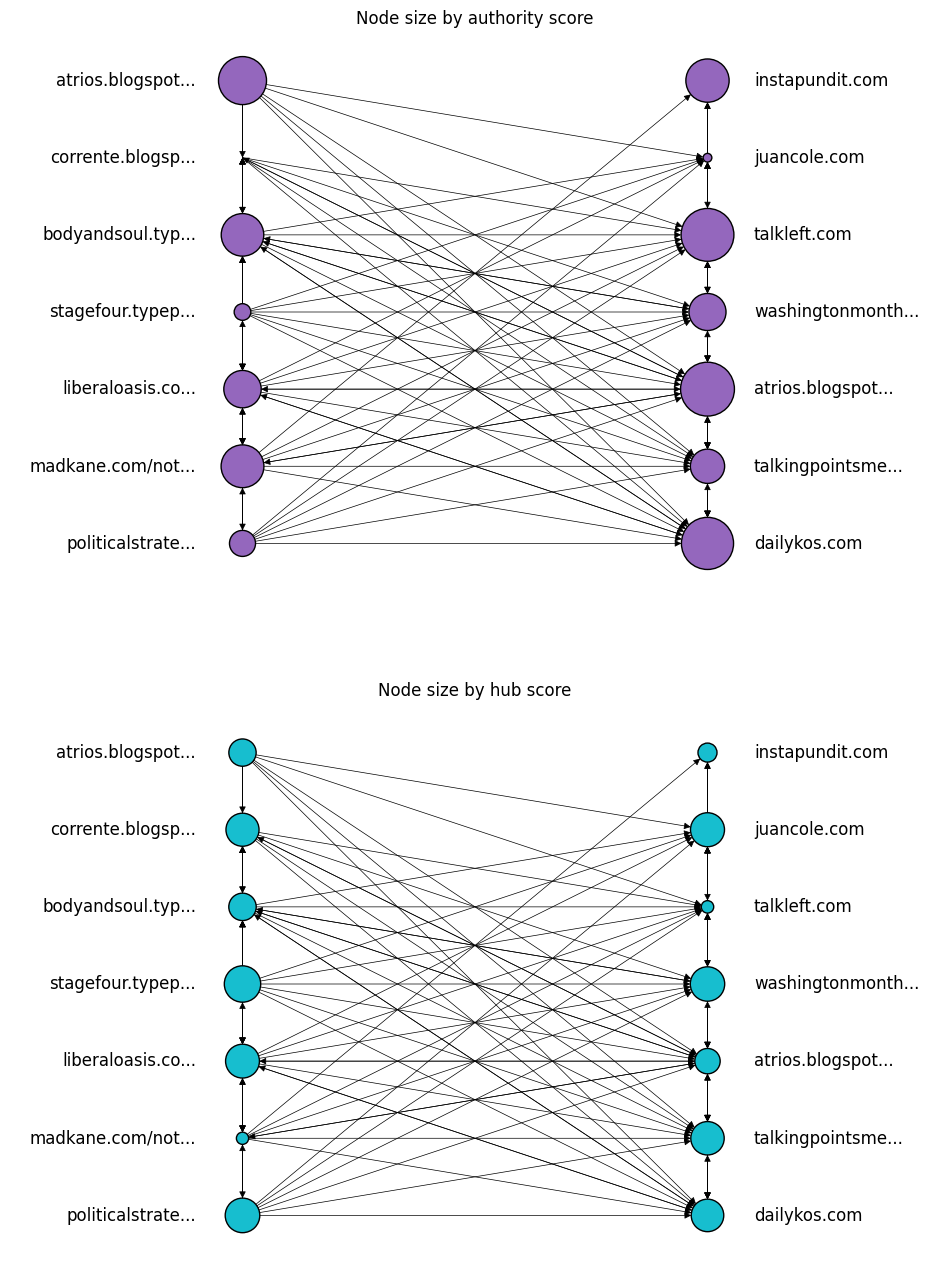

In [226]:
plt.figure(figsize=(12, 8*2))

h_labels = {i:i[:15] if len(i)<=15 else i[:15] + '...' for i in h_top}
a_labels = {i:i[:15] if len(i)<=15 else i[:15] + '...' for i in a_top}
a_pos = {node:(pos[node][0] + 0.1, pos[node][1]) for node in pos}
h_pos = {node:(pos[node][0] - 0.1, pos[node][1]) for node in pos}

cases = [[1, 'tab:purple', a_vals, 'Node size by authority score'], 
         [2, 'tab:cyan', h_vals, 'Node size by hub score']]
for i, color, vals, t in cases:
    plt.subplot(2, 1, i)
    plt.gca().axis('off')
    nx.draw_networkx(
        subG,
        pos,
        width=0.5,
        with_labels=False,
        edgecolors='black',
        node_size=vals*1e5,
        node_color=color
    )
    nx.draw_networkx_labels(
        subG,
        pos=a_pos,
        labels=a_labels,
        horizontalalignment='left'
    )
    nx.draw_networkx_labels(
        subG,
        pos=h_pos,
        labels=h_labels,
        horizontalalignment='right'
    )

    plt.xlim(-0.5, 1.5)
    plt.title(t)

## Community Detection

In [33]:
# ! pip install networkx --upgrade

In [69]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from zlib import adler32
from IPython.display import clear_output
import scipy

Try to detect communities in Les Miserables graph by Agglomerative clustering.

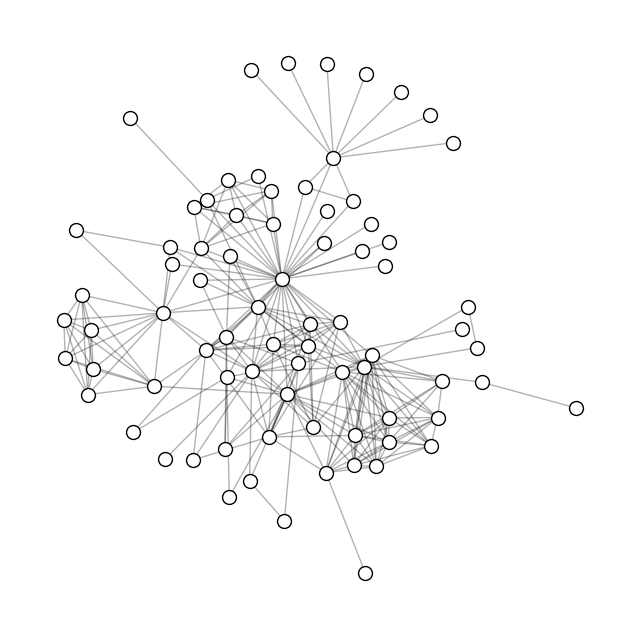

In [39]:
G = nx.Graph()
G.add_edges_from(nx.les_miserables_graph().edges)
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color='white', edgecolors='black', node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.axis('off')
plt.show()

### Agglomerative clustering (2.5 points)

Agglomerative clustering is an iterative procedure that unions similar clusters using a similarity matrix, but since we will run `sklearn.cluster.AgglomerativeClustering`, we need to pass a _distance_ matrix. So, first we need to choose a similarity measure and then convert it into a distance. Let us do it via SimRank measure that is defined as follows: _two objects are considered to be similar if they are referenced by similar objects_. Since SimRank takes values on the interval [0, 1], let us define a distance as

$$\text{Distance}= 1 - \text{SimRank}$$

Write a function `simrank_distance` that takes a graph and returns a distance matrix based on SimRank. Use `nx.simrank_similarity_numpy`. The distance matrix should be _absolutely_ symmetric.

не могу найти подходящую версию, просто скопировал код

In [36]:
def simrank_similarity_numpy(
    G,
    source=None,
    target=None,
    importance_factor=0.9,
    max_iterations=100,
    tolerance=1e-4,
):
    import numpy as np

    adjacency_matrix = nx.to_numpy_array(G)

    # column-normalize the ``adjacency_matrix``
    adjacency_matrix /= adjacency_matrix.sum(axis=0)

    newsim = np.eye(adjacency_matrix.shape[0], dtype=np.float64)
    for _ in range(max_iterations):
        prevsim = np.copy(newsim)
        newsim = importance_factor * np.matmul(
            np.matmul(adjacency_matrix.T, prevsim), adjacency_matrix
        )
        np.fill_diagonal(newsim, 1.0)

        if np.allclose(prevsim, newsim, atol=tolerance):
            break

    if source is not None and target is not None:
        return newsim[source, target]
    if source is not None:
        return newsim[source]
    return newsim

In [63]:
def simrank_distance(G):
    simrank_matrix = simrank_similarity_numpy(G)
    distance_matrix = 1 - simrank_matrix
    # Make distance matrix absolutely symmetric
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    return distance_matrix

In [64]:
distance = simrank_distance(G)
assert distance.shape == (77, 77)
assert np.diagonal(distance).sum() == 0
assert np.allclose(distance, distance.T, rtol=0, atol=0)
assert distance[52, 68] <= distance[1, 19]
assert distance[45, 29] <= distance[38, 46]

Then let us cluster nodes using `scipy.cluster.hierarchy.linkage`. The method takes distancies and returns an np.array with a matrix `Z` where every i-th row consists of
* `Z[i, 0]` and `Z[i, 1]` are indexes of combined clusters
* `Z[i, 2]` is the distance between combined clusters
* `Z[i, 3]` is the number of observations in combined clusters

Cluster with an index `n+i` is described in a i-th row of the matrix `Z`. Clusters with indexes less than `n+1` are initial nodes. The method `scipy.cluster.hierarchy.dendrogram` uses the matrix `Z` to plot a dendrogram. Let us look at a dendrogram of Les Miserables graph.

/tmp/ipykernel_18943/3519194390.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 800], [0.89, 0.89], 'k--', c='tab:red')


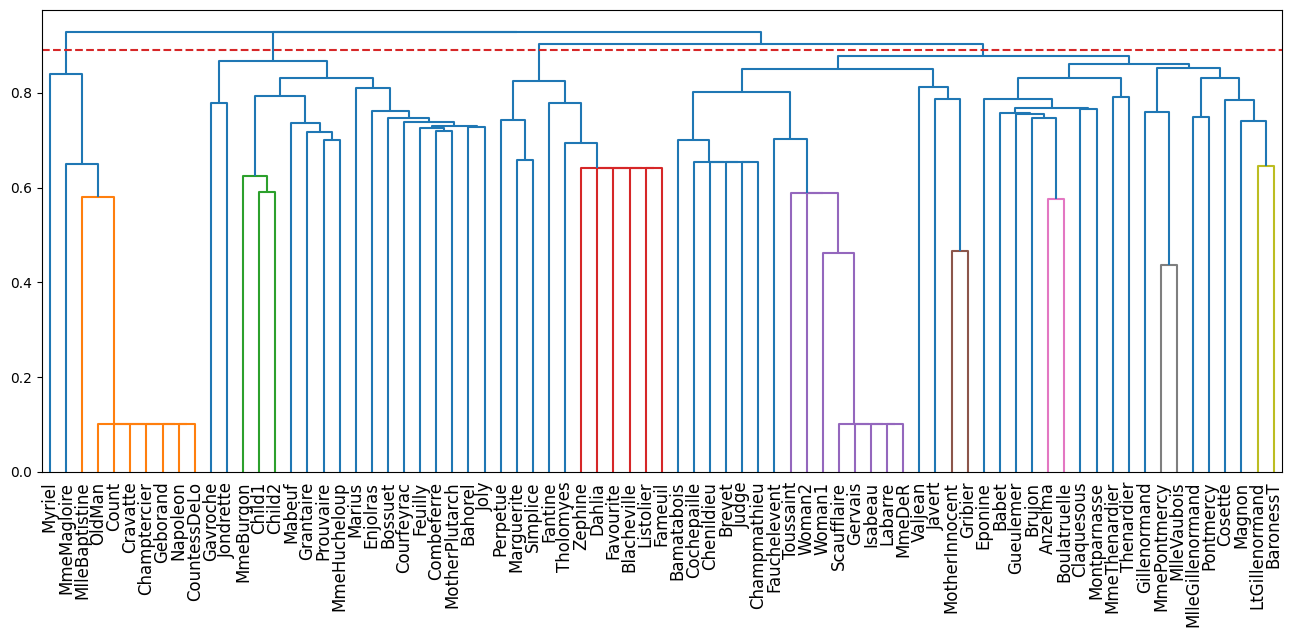

In [65]:
plt.figure(figsize=(16, 6))
linked = linkage(squareform(distance), 'complete')
dendrogram(linked, labels=list(G.nodes), 
           leaf_font_size=12)
plt.plot([0, 800], [0.89, 0.89], 'k--', c='tab:red')
plt.show()

Then we need to select a horizontal line that gives us a partitioning of the graph. There are two approaches: select the number of clusters, and select the maximal distance between clusters. For example, if we select a horicontal line with maximal distance 0.89 (a red line on the plot) then the number of clusters will be 4.

Write a function `agglomerative_clustering` that takes a distance matrix, maximal distance between clusters and returns an np.array with labels of clusters. Use `sklearn.cluster.AgglomerativeClustering` with complete linkage.

In [136]:
def agglomerative_clustering(distance, max_distance):
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=max_distance, linkage='complete',\
                                         affinity='precomputed').fit(distance)
    return clustering.labels_

In [138]:
assert len(set(agglomerative_clustering(distance, 0.8))) == 17
assert len(set(agglomerative_clustering(distance, 0.89))) == 4

/home/nikita/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/nikita/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


The graph with maximal distance 0.87

/home/nikita/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


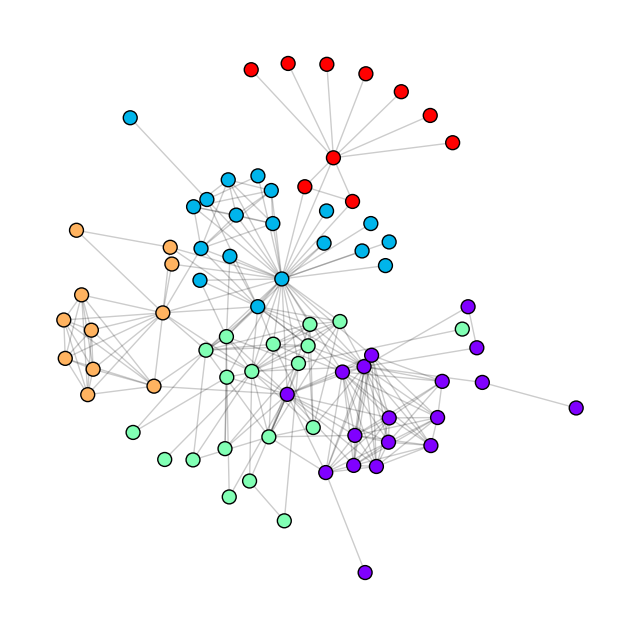

In [139]:
labels = agglomerative_clustering(distance, 0.87)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    G, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.show()

### Task 7. Louvain method (2.5 point)

Louvain method is one of the most cited works in the community detection literature. It is a simple method to extract the community structure of large networks. This method is a heuristic method that is based on modularity optimization. Let us consider this method on a fractal graph that can represent some biological structure.

In [140]:
def fractal_graph(n, k, G):
    if k == 0:
        return G
    for node in list(G.nodes):
        newG = nx.complete_graph(n)
        newG = nx.relabel_nodes(newG, {node:max(G.nodes)+node+1 for node in newG.nodes})
        G = nx.union(G, newG)
        for edge in G.edges(node):
            G.add_edge(list(G.nodes)[-1], edge[1])
        G.remove_node(node)
    return fractal_graph(n, k-1, G)

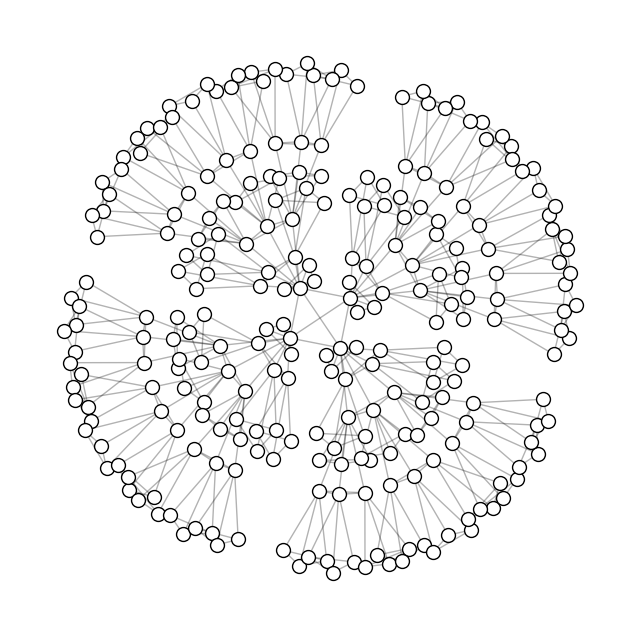

In [141]:
n = 4
fractalG = fractal_graph(n, 3, nx.complete_graph(n))

plt.figure(figsize=(8, 8))
frac_pos = nx.kamada_kawai_layout(fractalG)
nx.draw_networkx_nodes(fractalG, frac_pos, node_color='white', 
                       edgecolors='black', node_size=100)
nx.draw_networkx_edges(fractalG, frac_pos, alpha=0.3)
plt.axis('off')
plt.show()

Louvain method is a greedy algorithm of modularity gain that is described as: 

Phase 1
1. Put each node in its own community
2. For every node, calculate modularity gain by removing it from its community and placing it in neighbor's community
3. Put a node in the community with maximal modularity gain
4. Repeat 2, 3 until modularity stops increasing

Phase 2
1. Merge communities into ”super nodes”
2. Convert edges inside community into self loop, edges between communities into parallel edges

Repeat phases 1, 2 until modularity stops increasing.

In [177]:
def louvain_method(G):
    
    # Phase 1
    communities = unfolded_communities(G)
    labels = []
    for node in G.nodes:
        for i, c in enumerate(communities):
            if node in c:
                labels.append(i)
    
    # Phase 2
    nextG = nx.empty_graph(len(communities), nx.MultiGraph)
    for e in G.edges:
        for i in range(len(communities)):
            for j in range(len(communities)):
                if e[0] in communities[i] and e[1] in communities[j]:
                    nextG.add_edge(i, j)
                    
    # Shuffle colors for better visualization
    palette = np.unique(labels)
    key = np.random.permutation(palette)
    labels = key[np.digitize(labels, palette, right=True)]
    
    return communities, labels, nextG

Write a function `unfolded_communities` that takes a graph, performs Phase 1 and returns np.array of communities with nodes. For example, if there are two communitites: the first is [1,2] and the second is [3,4,5] then the output will be [[1,2],[3,4,5]].

In [178]:
def unfolded_communities(G):
    # Proposed template:
    communities = [[n] for n in G.nodes] # initial partition
    prev_max_modularity = -np.inf
    max_modularity = nx.algorithms.community.modularity(G, communities)
    while max_modularity > prev_max_modularity:
        prev_max_modularity = max_modularity
        for node in np.random.permutation(G.nodes): 
            mod_step = -np.inf
            idx_max = 0 
            #find which cluster node is in
            for idx, com in enumerate(communities):
                if node in com:
                    com_idx = idx
            communities[com_idx].remove(node)
            #where to insert
            for i, comm in enumerate(communities):
                comm.append(node)
                modularity = nx.algorithms.community.modularity(G, communities)
                if modularity > mod_step:
                    idx_max = i
                    mod_step = modularity
                comm.remove(node)

            if mod_step > max_modularity:
                max_modularity = mod_step
            communities[idx_max].append(node)
            
    
    return [c for c in communities if len(c)]

In [180]:
# unfolded_communities(iterG)

In [181]:
n = 4
fractalG = fractal_graph(n, 2, nx.complete_graph(n))
iterG = fractalG.copy()
communities, labels, nextG = louvain_method(iterG)

assert len(set(labels)) == 16
assert len(set(labels[52:56])) == 1
assert len(set(labels[52:57])) == 2
assert nextG.number_of_nodes() == 16
assert round(np.linalg.det(nx.to_numpy_array(nextG)) * 1e-10, 4) == 136.5257

Let us see unfolding iterations. For every iteration we draw a graph where node color corresponds to the unfolded community.

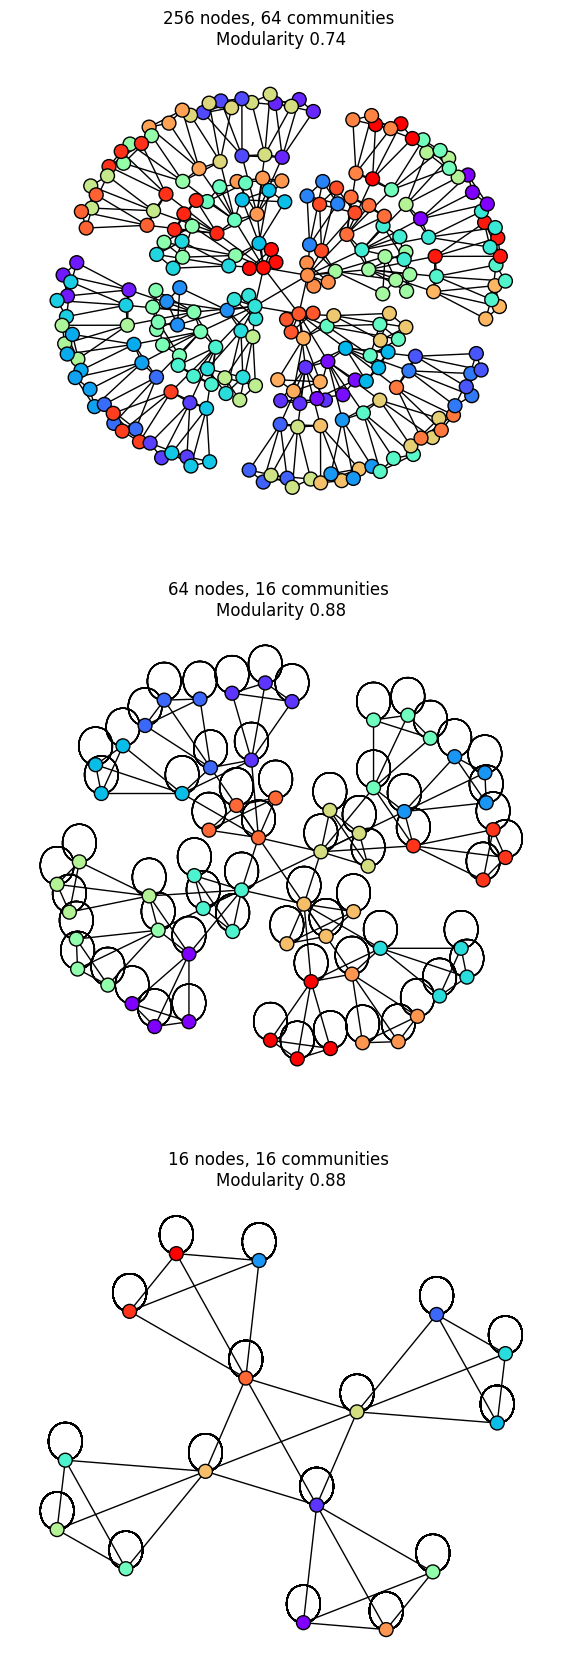

In [182]:
n = 4
fractalG = fractal_graph(n, 3, nx.complete_graph(n))
iterG = fractalG

plt.figure(figsize=(7, 7*3))
for i in range(3):
    plt.subplot(3, 1, i+1)
    communities, labels, nextG = louvain_method(iterG)
    iter_pos = nx.kamada_kawai_layout(iterG)
    nodes = nx.draw_networkx_nodes(
        iterG,
        iter_pos,
        cmap=plt.cm.rainbow,
        node_color=labels,
        edgecolors='black',
        node_size=100)
    nx.draw_networkx_edges(
        iterG,
        iter_pos,
        node_size=100)
    plt.axis('off')
    plt.title(
        '{} nodes, {} communities \nModularity {:.2f}'.format(
            len(iterG), len(communities), nx.community.modularity(iterG, communities)))
    iterG = nextG